### This kernel experiments with various data augmentation techniques for facial keypoint detection.

## Importing Necessary Packages

In [1]:
# Making necessary imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


### Augmentation & Hyperparameter Settings
#### Experiment with various augmentation choices

In [2]:
horizontal_flip = False
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True

include_unclean_data = True    # Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.
sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

NUM_EPOCHS = 80
BATCH_SIZE = 64

## Extracting files to working directory

In [3]:
print("Contents of input/facial-keypoints-detection directory: ")
!ls ../input/facial-keypoints-detection/

print("\nExtracting .zip dataset files to working directory ...")
!unzip -u ../input/facial-keypoints-detection/test.zip
!unzip -u ../input/facial-keypoints-detection/training.zip

print("\nCurrent working directory:")
!pwd
print("\nContents of working directory:")
!ls

Contents of input/facial-keypoints-detection directory: 
IdLookupTable.csv  SampleSubmission.csv  test.zip  training.zip

Extracting .zip dataset files to working directory ...
Archive:  ../input/facial-keypoints-detection/test.zip
  inflating: test.csv                
Archive:  ../input/facial-keypoints-detection/training.zip
  inflating: training.csv            

Current working directory:
/kaggle/working

Contents of working directory:
__notebook__.ipynb  test.csv  training.csv


## Reading inputs to a Pandas DataFrame

In [4]:
%%time

train_file = 'training.csv'
test_file = 'test.csv'
idlookup_file = '../input/facial-keypoints-detection/IdLookupTable.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
idlookup_data = pd.read_csv(idlookup_file)

CPU times: user 2.4 s, sys: 350 ms, total: 2.75 s
Wall time: 2.76 s


#### Function to plot facial keypoints with images

In [5]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

## Exploring Data

In [6]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [7]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [8]:
idlookup_data.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


### Check for any images with missing pixel values

In [9]:
print("Length of train data: {}".format(len(train_data)))
print("Number of Images with missing pixel values: {}".format(len(train_data) - int(train_data.Image.apply(lambda x: len(x.split())).value_counts().values)))

Length of train data: 7049
Number of Images with missing pixel values: 0


### Find columns having Null values and their counts

In [10]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

#### We can observe that approx. 68% of data is missing for several keypoints

In [11]:
%%time

clean_train_data = train_data.dropna()
print("clean_train_data shape: {}".format(np.shape(clean_train_data)))

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(unclean_train_data)))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)

CPU times: user 7.88 ms, sys: 2.12 ms, total: 10 ms
Wall time: 13.3 ms


### Separate data into clean & unclean subsets

Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)

CPU times: user 41.3 s, sys: 2.73 s, total: 44.1 s
Wall time: 44.4 s


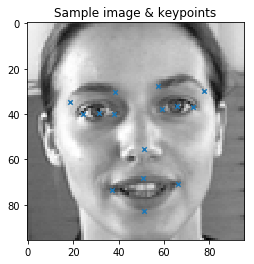

In [12]:
%%time

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Sample image & keypoints")

if include_unclean_data:
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

## Performing Horizontal Flipping for Data Augmentation

In [13]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

## Performing Rotation Augmentation

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



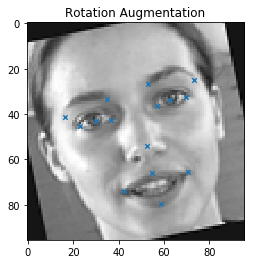

In [14]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

## Performing Brightness Alteration for Data Augmentation

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


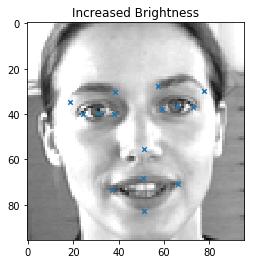

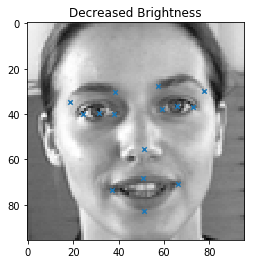

In [15]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 

## Performing Horizontal & Vertical shift

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


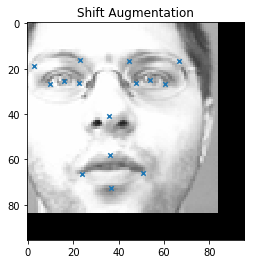

In [16]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

## Adding Random Noise for Data Augmentation

Shape of noisy_train_images: (2140, 96, 96, 1)


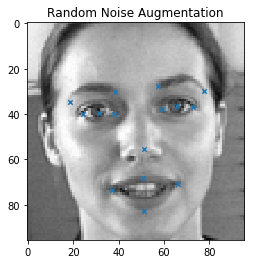

In [17]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")

## Visualize Train images & corresponding Keypoints

Shape of final train_images: (26239, 96, 96, 1)
Shape of final train_keypoints: (26239, 30)

 Clean Train Data: 


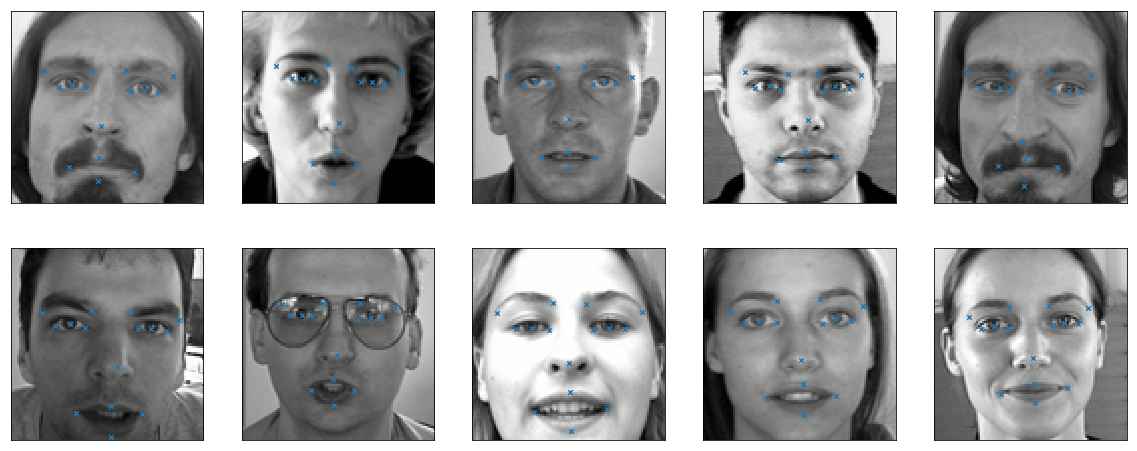

Unclean Train Data: 


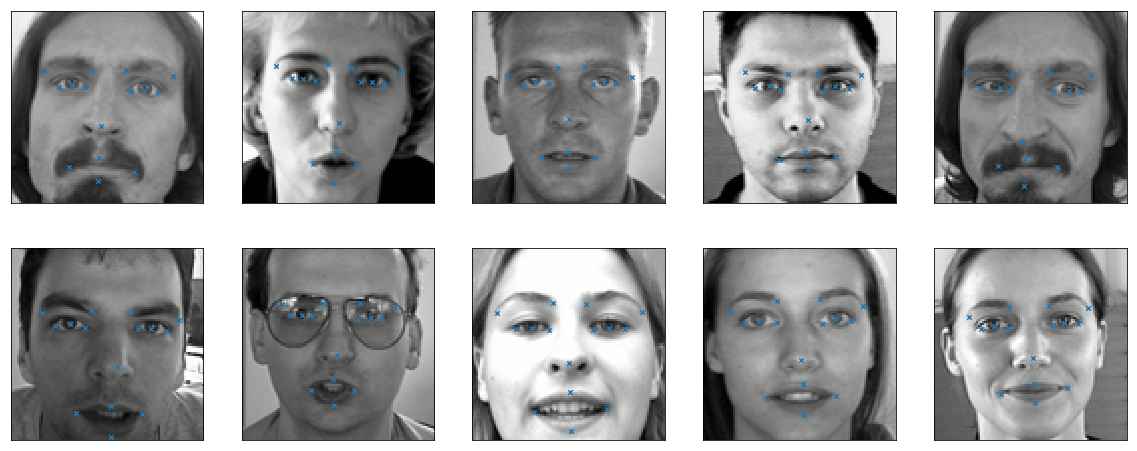

Rotation Augmentation: 


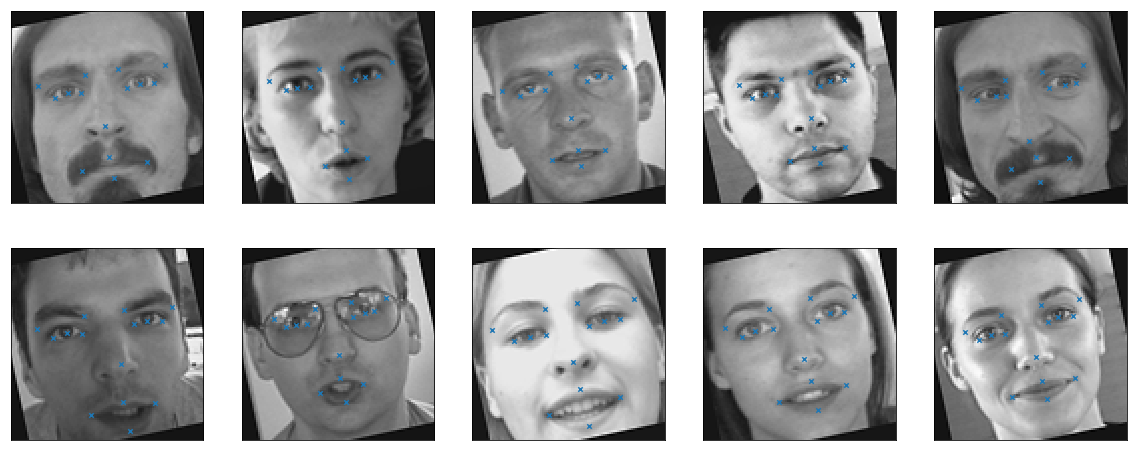

Brightness Augmentation: 


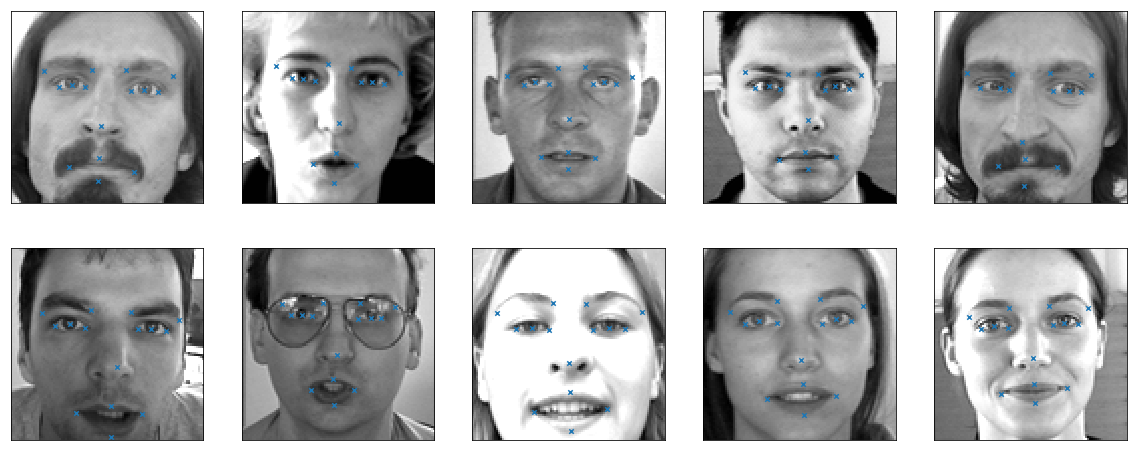

Shift Augmentation: 


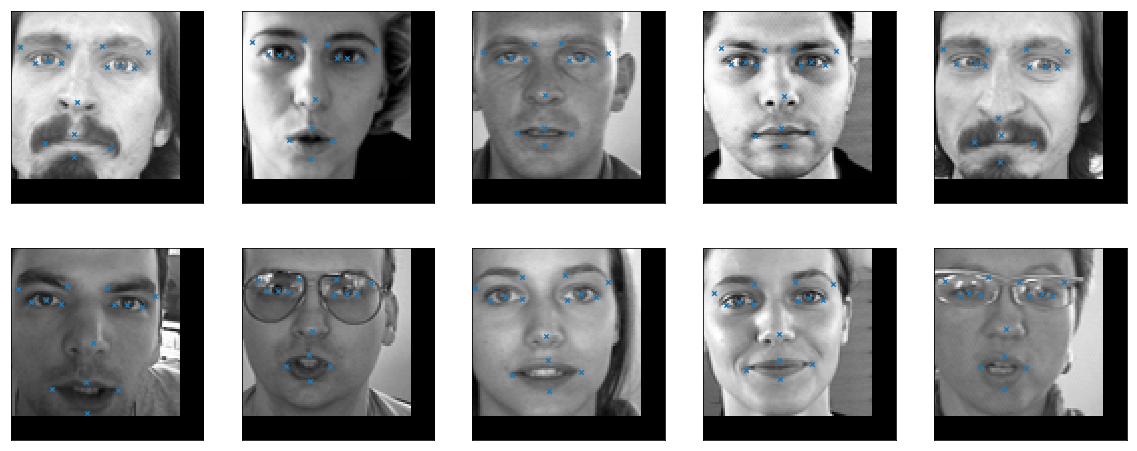

Random Noise Augmentation: 


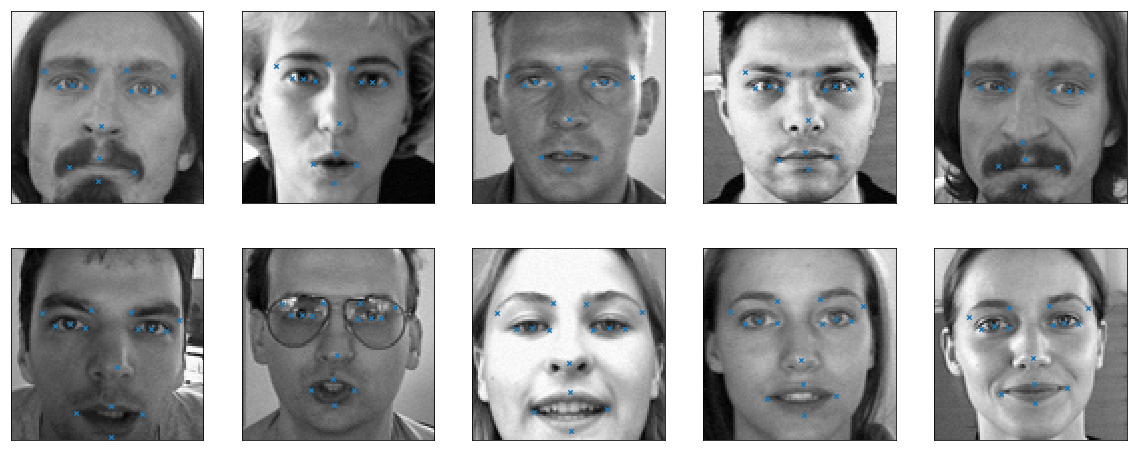

In [18]:
print("Shape of final train_images: {}".format(np.shape(train_images)))
print("Shape of final train_keypoints: {}".format(np.shape(train_keypoints)))

print("\n Clean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

if include_unclean_data:
    print("Unclean Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
    plt.show()

if horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

## Building a model

In [19]:
model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)       

## Training the model

In [20]:
%%time

# Load a pre-trained model (if present)
if os.path.exists('../input/data-augmentation-for-facial-keypoint-detection/best_model.hdf5'):
    model = load_model('../input/data-augmentation-for-facial-keypoint-detection/best_model.hdf5')

# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# Train the model
history = model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.05, callbacks=[checkpointer])

Train on 24927 samples, validate on 1312 samples
Epoch 1/80
24927/24927 [==============================] - 32s 1ms/step - loss: 3.1259 - mae: 1.3213 - acc: 0.8954 - val_loss: 0.5415 - val_mae: 0.5723 - val_acc: 0.9070

Epoch 00001: val_mae improved from inf to 0.57230, saving model to best_model.hdf5
Epoch 2/80
24927/24927 [==============================] - 25s 991us/step - loss: 2.8113 - mae: 1.2729 - acc: 0.8945 - val_loss: 1.4287 - val_mae: 0.9767 - val_acc: 0.8872

Epoch 00002: val_mae did not improve from 0.57230
Epoch 3/80
24927/24927 [==============================] - 25s 1ms/step - loss: 2.9064 - mae: 1.2984 - acc: 0.8931 - val_loss: 0.6769 - val_mae: 0.6128 - val_acc: 0.8925

Epoch 00003: val_mae did not improve from 0.57230
Epoch 4/80
24927/24927 [==============================] - 25s 995us/step - loss: 2.9132 - mae: 1.3016 - acc: 0.8929 - val_loss: 0.7838 - val_mae: 0.6898 - val_acc: 0.8659

Epoch 00004: val_mae did not improve from 0.57230
Epoch 5/80
24927/24927 [==========

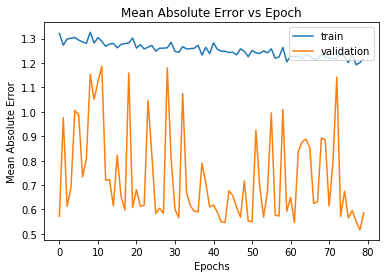

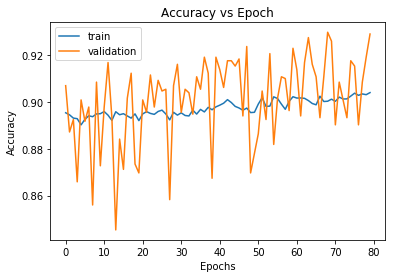

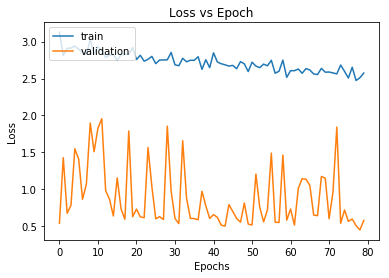

In [21]:
# summarize history for mean_absolute_error
try:
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

### Fit the model on full dataset

In [22]:
%%time

# Modify ModelCheckpoint callback to save model with best train mae to disk (instead of best validation mae)
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='mae', verbose=1, save_best_only=True, mode='min')
model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])

Epoch 1/80
26239/26239 [==============================] - 26s 990us/step - loss: 2.4848 - mae: 1.1951 - acc: 0.8976

Epoch 00001: mae improved from inf to 1.19512, saving model to best_model.hdf5
Epoch 2/80
26239/26239 [==============================] - 26s 983us/step - loss: 2.6426 - mae: 1.2385 - acc: 0.9016

Epoch 00002: mae did not improve from 1.19512
Epoch 3/80
26239/26239 [==============================] - 26s 972us/step - loss: 2.5320 - mae: 1.2104 - acc: 0.8996

Epoch 00003: mae did not improve from 1.19512
Epoch 4/80
26239/26239 [==============================] - 26s 988us/step - loss: 2.4939 - mae: 1.2021 - acc: 0.9007

Epoch 00004: mae did not improve from 1.19512
Epoch 5/80
26239/26239 [==============================] - 25s 971us/step - loss: 2.5103 - mae: 1.2045 - acc: 0.9014

Epoch 00005: mae did not improve from 1.19512
Epoch 6/80
26239/26239 [==============================] - 26s 982us/step - loss: 2.4588 - mae: 1.1892 - acc: 0.9001

Epoch 00006: mae improved from 1.19

## Predicting on Test Set

In [23]:
%%time
 
model = load_model('best_model.hdf5')
test_preds = model.predict(test_images)

CPU times: user 5.84 s, sys: 223 ms, total: 6.06 s
Wall time: 6.26 s


## Visualizing Test Predictions

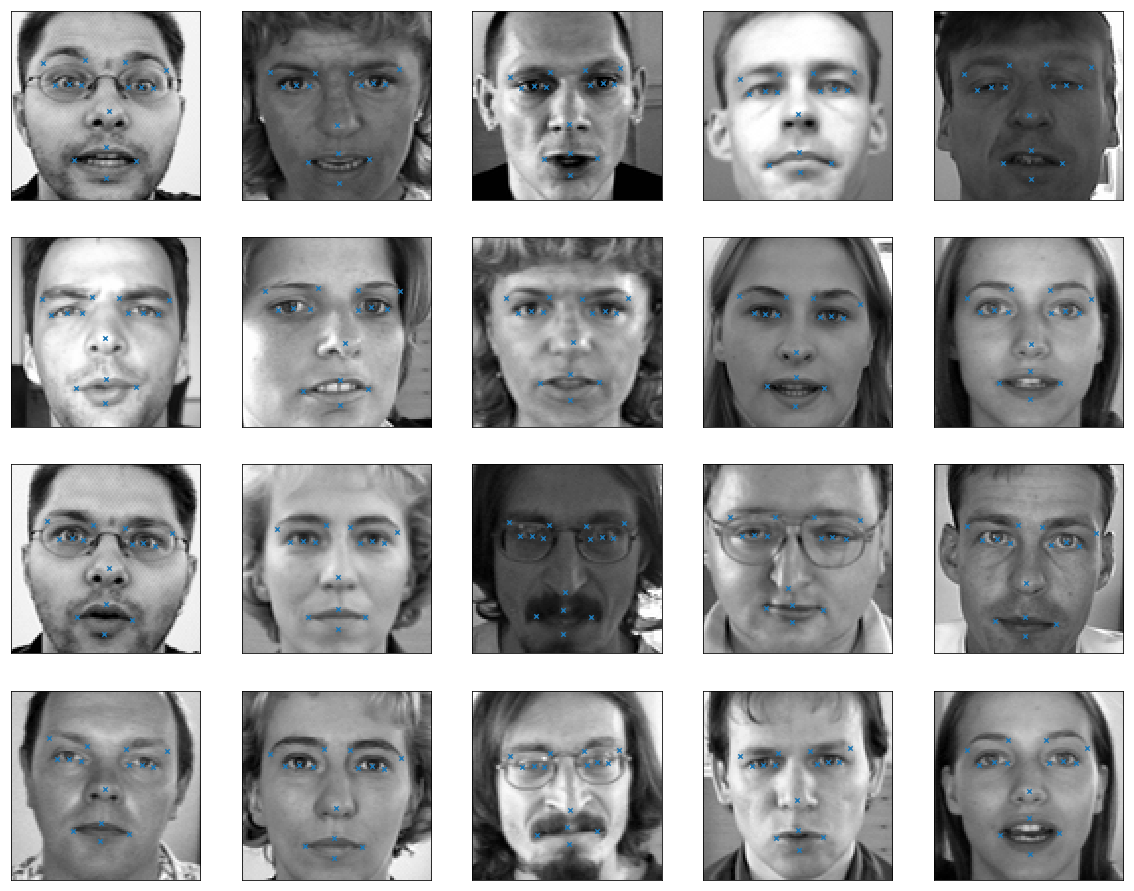

In [24]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")
plt.show()

## Generating Submission File

In [25]:
feature_names = list(idlookup_data['FeatureName'])
image_ids = list(idlookup_data['ImageId']-1)
row_ids = list(idlookup_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

### If this notebook helped, please upvote it :)